In [1]:
import scipy as sc
import imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [16]:
import os, json
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

In [3]:
path = "/home/zelenyy/storage/data/sri-satellite/BAT/proton/"

In [4]:
sims = list(filter(lambda x: x[:3]=="sim", os.listdir(path)))

In [5]:
res_parse= []
for sim in sims:
    path_deposit = os.path.join(path, sim, 'data/deposit.txt')
    path_meta = os.path.join(path, sim, 'meta.json')
    with open(path_meta, 'r') as pm:
        meta = json.load(pm)
    deposit = np.loadtxt(path_deposit)
    res_parse.append([meta['energy'], meta['number'], deposit])
    

In [6]:
res_parse

[[41, 10000, array([[  1.83382000e+00,   1.11899000e-02],
         [  1.90914000e+00,   1.04875000e-02],
         [  1.98499000e+00,   1.09860000e-02],
         [  2.07871000e+00,   1.12388000e-02],
         [  2.18985000e+00,   1.10037000e-02],
         [  2.33048000e+00,   1.15404000e-02],
         [  2.49791000e+00,   1.12949000e-02],
         [  2.70664000e+00,   1.18941000e-02],
         [  2.99588000e+00,   1.34450000e-02],
         [  3.40621000e+00,   1.65092000e-02],
         [  4.10117000e+00,   3.06154000e-02],
         [  5.70984000e+00,   2.07503000e-01],
         [  7.25442000e+00,   1.21967000e+00],
         [  9.35093000e-04,   1.73304000e-03],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
  

In [7]:
energy = np.array([i[0] for i in res_parse])
number = np.array([i[1] for i in res_parse])

In [8]:
mean = np.zeros((65, 100))
for i in range(100):
    indx = int(res_parse[i][0])
    mean[:,indx-1] = res_parse[i][2][:65,0] 

In [9]:
energy.sort()

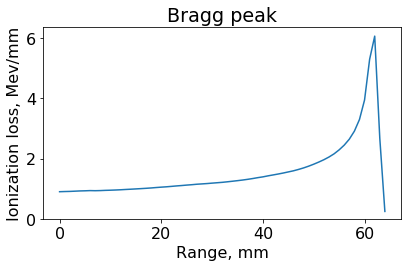

In [106]:
# plt.errorbar(range(65), res_parse[9][2][:65,0], yerr=res_parse[9][2][:65,1], fmt='.')
plt.plot(range(65), res_parse[9][2][:65,0])
plt.ylim(0.0)
plt.xlabel("Range, mm")
plt.ylabel("Ionization loss, Mev/mm")
plt.title("Bragg peak");
plt.tight_layout()
plt.savefig('Bragg peak.svg', format='svg', trasparent=True);

In [20]:
inter = interp1d(energy, mean[10])

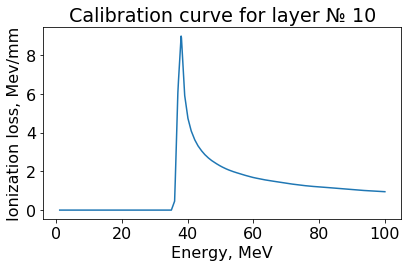

In [105]:
x = np.linspace(1,100,1000)
plt.plot(x, inter(x))
plt.xlabel('Energy, MeV')
plt.ylabel("Ionization loss, Mev/mm")
plt.title("Calibration curve for layer № 10")
plt.tight_layout()
plt.savefig('Calibration.svg', format='svg', trasparent=True);

In [25]:
Kernels = [interp1d(energy, mean[i,:], kind='cubic') for i in range(65)]

def kernel(x, y):
    i = int(y)
    return Kernels[i](x)

In [26]:
import sys
sys.path.append('/home/zelenyy/npm/stats/statreg-py')

In [27]:
from statreg.deconvolution import GaussErrorMatrixUnfolder
from statreg.basis import CubicSplines

In [28]:
bas =CubicSplines(energy)

In [29]:
Kmn = bas.discretizeKernel(kernel, np.arange(65))

In [30]:
omega = bas.omega(2)

In [31]:
model = GaussErrorMatrixUnfolder(omega)

In [95]:
# path = "/home/zelenyy/storage/data/sri-satellite/BAT/gauss/data/"
path = "/home/zelenyy/storage/data/sri-satellite/BAT/pow/data/"

In [96]:
deposit = np.loadtxt(os.path.join(path, 'deposit.txt'), dtype=[("mean", 'd'), ('sigma', 'd')])
primary = np.loadtxt(os.path.join(path, 'primary.txt') )

In [34]:
from scipy.stats import norm

In [37]:
KmnR = np.round(Kmn, 3)

In [56]:
KmnR.shape

(65, 100)

In [97]:
f = deposit['mean'][:65]*10000
f = deposit['mean'][:63]*10000
sig = f**0.5
beamRes = model.solve(KmnR[:63], f, sig)

/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:532: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[k] = func(sim[k])
/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:557: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxe
/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxcc


In [53]:
1400/110

12.727272727272727

In [41]:
from scipy.integrate import quad

/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [43]:
from statreg.vector import PhiVec

In [100]:
phi = PhiVec(beamRes.phi, bas, sig= beamRes.covariance)
norm = quad(phi, 10,100, limit=100)[0]

/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


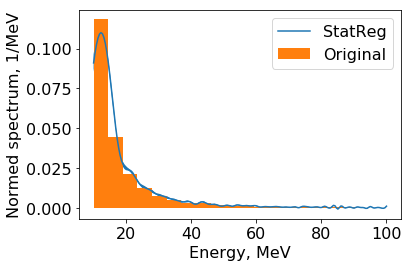

In [103]:
x = np.linspace(10,100, 200)
y = phi(x)/norm
dy = phi.error(x)/norm
plt.plot(x, phi(x)/norm, label = 'StatReg')
plt.fill_between(x, y-dy,y+dy)

plt.hist(primary, bins=20, density=True,label= 'Original')
plt.ylabel("Normed spectrum, 1/MeV")
plt.xlabel("Energy, MeV")
plt.legend();
plt.tight_layout()
plt.savefig('Pow.svg', format='svg', trasparent=True);

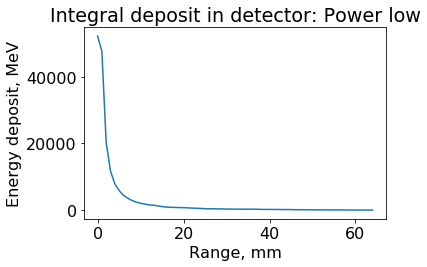

In [83]:
# pDep = deposit['mean'][:65]*10000
plt.plot(pDep)
plt.ylabel('Energy deposit, MeV')
plt.xlabel("Range, mm")
plt.title("Integral deposit in detector: Power low")
plt.tight_layout()
plt.savefig('IntegralPow.svg', format='svg', trasparent=True);

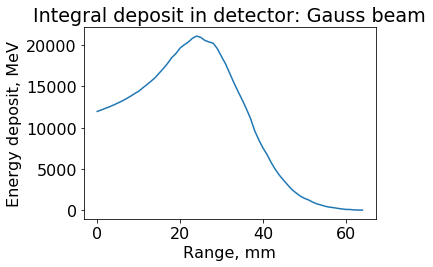

In [84]:
# gDep = deposit['mean'][:65]*10000
plt.plot(gDep)
plt.ylabel('Energy deposit, MeV')
plt.xlabel("Range, mm")
plt.title("Integral deposit in detector: Gauss beam");
plt.tight_layout()
plt.savefig('IntegralGauss.svg', format='svg', trasparent=True);

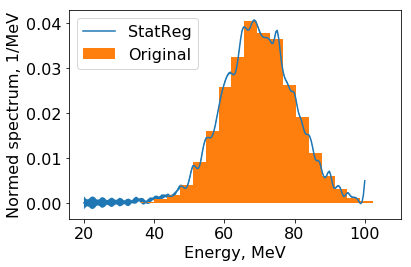

In [94]:
x = np.linspace(20,100, 200)
y = phi(x)/norm
dy = phi.error(x)/norm
plt.plot(x, phi(x)/norm, label = 'StatReg')
plt.fill_between(x, y-dy,y+dy)

plt.hist(primary, bins=20, density=True,label= 'Original')
plt.ylabel("Normed spectrum, 1/MeV")
plt.xlabel("Energy, MeV")
plt.legend();
plt.tight_layout()
plt.savefig('BeamDumping.svg', format='svg', trasparent=True);